In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
# Seaborn for plotting and styling
import seaborn as sns
import matplotlib.pyplot as mp
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv('dataset/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
features = ['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']
merge_count=0
df_X = df[features]
df_X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [8]:
df_y = df['Exited']
df_y.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [9]:
#df_X_train,df_X_test,df_y_train,df_y_test = train_test_split( df_X, df_y, train_size=0.8, test_size=0.2)
#print(df_X_train.shape,df_X_test.shape,df_y_train.shape,df_y_test.shape)

In [10]:
df_X.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [11]:
df_X.nunique()

CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
dtype: int64

In [12]:
categorical_col = list(df_X.columns[df_X.dtypes == 'object'])
categorical_col

['Geography', 'Gender']

In [13]:
continues_col = list(df_X.columns[df_X.nunique() > 4])
continues_col

['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [14]:
zero_containing_col = ['HasCrCard','IsActiveMember'] 
zero_containing_col

['HasCrCard', 'IsActiveMember']

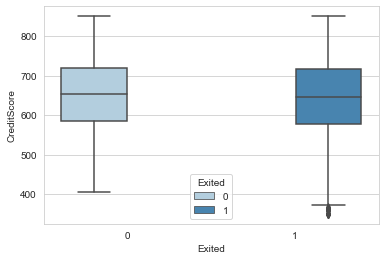

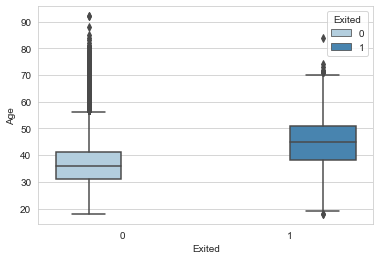

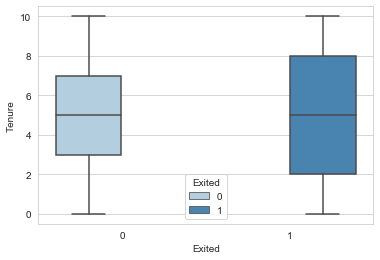

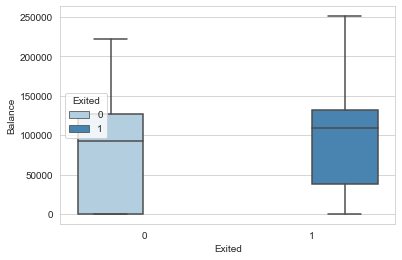

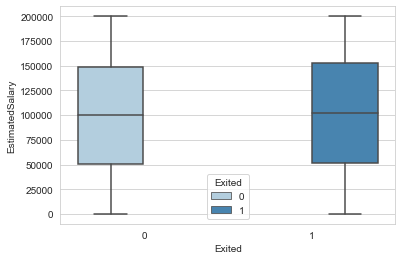

In [15]:
#Box Plot for continuous variables
def box_plot_func(continuous_list):
    for colname in continuous_list:
        sns.set_style("whitegrid") 
        sns.boxplot(y=df_X[colname], x='Exited', data=df, hue='Exited',color ='Red',dodge = True,palette="Blues")
        mp.show()
        mp.clf()
        mp.close()
#Call the user-defined function to plot graph on exited vs Continuous Variables        
box_plot_func(continues_col)
mp.show()
mp.clf()
mp.close()

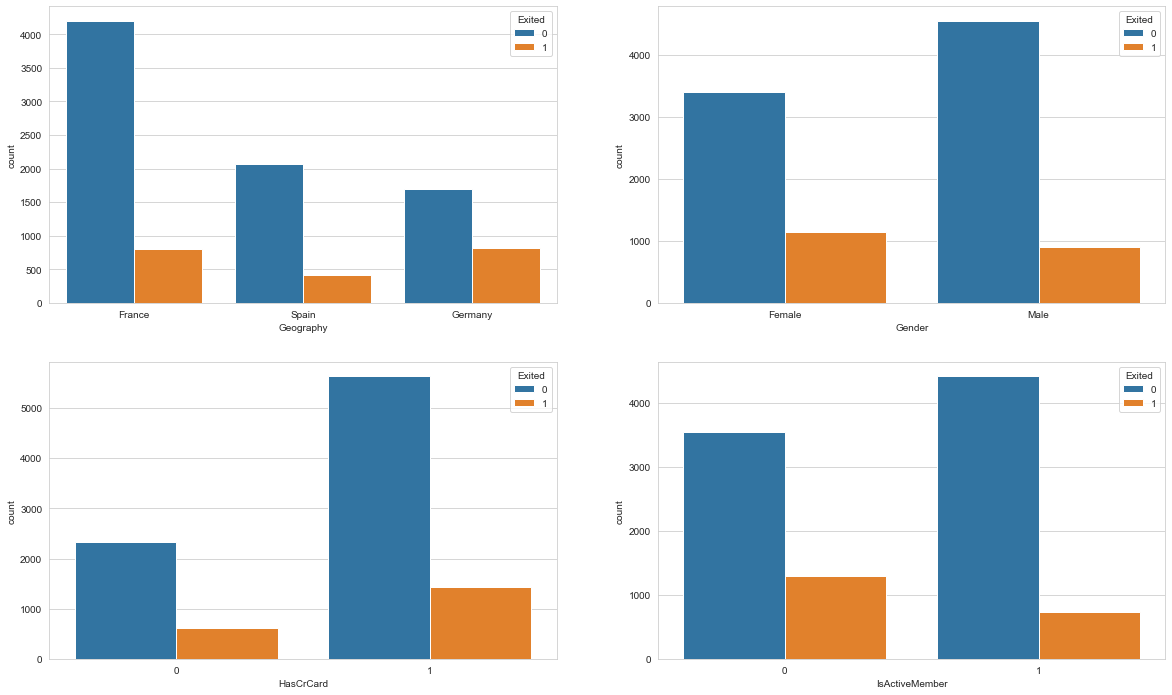

In [16]:
#Bar Graph/Count Plot
#To plot categorical variables on the bar graph
fig, axarr = mp.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

In [17]:
#Both HasCrCard and IsActiveMember has zero values,hence replacement of zeroes to a non-negative value is done for easy computations of model algorithms
df_X.loc[df_X.HasCrCard == 0, 'HasCrCard'] = -1
df_X.loc[df_X.IsActiveMember == 0, 'IsActiveMember'] = -1
df_X.head()

C:\Users\harshasingh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,-1,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,-1,113931.57
3,699,France,Female,39,1,0.00,2,-1,-1,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [18]:
#Handling categorical variables clubbing by using one-hot encoder process is done
def handle_cat(catag_col,df_temp):
    for var in catag_col:
        for val in df_temp[var].unique():
            df_temp[var+"_"+val] = np.where(df_temp[var] == val,1,-1)
        df_temp = df_temp.drop(var,axis=1)
    return df_temp
df_X = handle_cat(categorical_col,df_X)
df_X.head()

C:\Users\harshasingh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,-1,-1,1,-1
1,608,41,1,83807.86,1,-1,1,112542.58,-1,1,-1,1,-1
2,502,42,8,159660.80,3,1,-1,113931.57,1,-1,-1,1,-1
3,699,39,1,0.00,2,-1,-1,93826.63,1,-1,-1,1,-1
4,850,43,2,125510.82,1,1,1,79084.10,-1,1,-1,1,-1


In [19]:
continues_col

['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [20]:
#df_X_train['Balance/EstimatedSalary'] = df_X_train['Balance']/df_X_train['EstimatedSalary']

def divide_and_add_col(col1,col2,df_temp):
    df_temp[col1+"/"+col2] = df_temp[col1]/df_temp[col2]
    return df_temp

#divide_and_add_col.counter=0
#Balance/EstimatedSalary
df_X = divide_and_add_col('Balance','EstimatedSalary',df_X)


#Age/Tenure
df_X = divide_and_add_col('Tenure','Age',df_X)


#CreditedScore/Tenure
df_X = divide_and_add_col('Tenure','CreditScore',df_X)


#EstimatedSalary/NumOFProducts
#df_X = divide_and_add_col(continues_col[5],continues_col[4],df_X)
df_X = df_X.drop(continues_col,axis=1)


In [21]:
df_X.isin([np.inf,-np.inf])

,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male,Balance/EstimatedSalary,Tenure/Age,Tenure/CreditScore
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False


In [22]:
def normalization_fun(col, df_temp):
    df_temp[col] = (df_X[col]-df_X[col].min())/(df_X.loc[df_X[col] != np.inf, col].max() -df_X[col].min())
    return df_temp

df_X = normalization_fun('Balance/EstimatedSalary',df_X)
df_X = normalization_fun('Tenure/Age',df_X)
df_X = normalization_fun('Tenure/CreditScore',df_X)
#df_X = normalization_fun('EstimatedSalary/NumOfProducts',df_X)




In [23]:
df_X.head()

,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male,Balance/EstimatedSalary,Tenure/Age,Tenure/CreditScore
0,1,1,1,1,-1,-1,1,-1,0.000000,0.085714,0.113086
1,1,-1,1,-1,1,-1,1,-1,0.000070,0.043902,0.057566
2,3,1,-1,1,-1,-1,1,-1,0.000132,0.342857,0.557769
3,2,-1,-1,1,-1,-1,1,-1,0.000000,0.046154,0.050072
4,1,1,1,-1,1,-1,1,-1,0.000150,0.083721,0.082353


In [24]:
df_X_train,df_X_test,df_y_train,df_y_test = train_test_split( df_X, df_y, train_size=0.8, test_size=0.2)
print(df_X_train.shape,df_X_test.shape,df_y_train.shape,df_y_test.shape)

(8000, 11) (2000, 11) (8000,) (2000,)


In [25]:
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    


In [26]:
# Fit primal logistic regression
param_grid = {'C': [0.1,0.5,1,10,50,100], 'max_iter': [250], 'fit_intercept':[True],'intercept_scaling':[1],
              'penalty':['l2'], 'tol':[0.00001,0.0001,0.000001]}
log_primal_Grid = GridSearchCV(LogisticRegression(solver='lbfgs'),param_grid, cv=10, refit=True, verbose=0)
log_primal_Grid.fit(df_X_train,df_y_train)
best_model(log_primal_Grid)

0.8045
{'C': 100, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 250, 'penalty': 'l2', 'tol': 1e-05}
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=250,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-05, verbose=0,
                   warm_start=False)


In [27]:
logistic_alg = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=250, multi_class='warn',n_jobs=None, 
                                penalty='l2', random_state=2, solver='lbfgs',tol=1e-05, verbose=0, warm_start=False)
result = logistic_alg.fit(df_X_train,df_y_train)


In [28]:
df_y_pred = logistic_alg.predict(df_X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logistic_alg.score(df_X_test, df_y_test)))

Accuracy of logistic regression classifier on test set: 0.80


In [29]:
print(classification_report(df_y_test,logistic_alg.predict(df_X_test)))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1600
           1       0.54      0.11      0.19       400

    accuracy                           0.80      2000
   macro avg       0.68      0.54      0.54      2000
weighted avg       0.76      0.80      0.75      2000



In [30]:
auc_score=roc_auc_score(df_y_test,logistic_alg.predict(df_X_test))
print(auc_score)

0.544375


In [31]:
fpr,tpr,mpr = roc_curve(df_y_test,logistic_alg.predict_proba(df_X_test)[:,1])
print(fpr,tpr,mpr)

[0.00000e+00 0.00000e+00 6.25000e-04 6.25000e-04 1.25000e-03 1.25000e-03
 1.87500e-03 1.87500e-03 2.50000e-03 2.50000e-03 3.12500e-03 3.12500e-03
 3.75000e-03 3.75000e-03 4.37500e-03 4.37500e-03 5.00000e-03 5.00000e-03
 6.87500e-03 6.87500e-03 7.50000e-03 7.50000e-03 1.12500e-02 1.12500e-02
 1.18750e-02 1.18750e-02 1.25000e-02 1.25000e-02 1.31250e-02 1.31250e-02
 1.37500e-02 1.37500e-02 1.43750e-02 1.43750e-02 1.50000e-02 1.50000e-02
 1.56250e-02 1.56250e-02 1.93750e-02 1.93750e-02 2.31250e-02 2.31250e-02
 2.37500e-02 2.37500e-02 2.43750e-02 2.43750e-02 2.50000e-02 2.50000e-02
 2.62500e-02 2.62500e-02 2.68750e-02 2.68750e-02 2.81250e-02 2.81250e-02
 2.87500e-02 2.87500e-02 3.37500e-02 3.37500e-02 3.50000e-02 3.50000e-02
 3.56250e-02 3.56250e-02 3.68750e-02 3.68750e-02 3.75000e-02 3.75000e-02
 3.81250e-02 3.81250e-02 3.87500e-02 3.87500e-02 3.93750e-02 3.93750e-02
 4.00000e-02 4.00000e-02 4.12500e-02 4.12500e-02 4.25000e-02 4.25000e-02
 4.31250e-02 4.31250e-02 4.43750e-02 4.43750e-02 4.

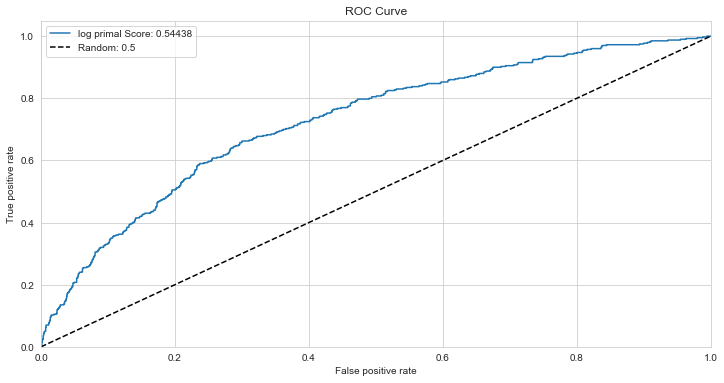

In [32]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr,tpr,label = 'log primal Score: ' + str(round(auc_score, 5)))
plt.plot([0,1], [0,1], '--k', label = 'Random: 0.5')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [33]:
logistic_alg.score(df_X_train, df_y_train)

0.80325

In [34]:
logistic_alg.predict_proba(df_X)[:,1]

array([0.17595639, 0.191387  , 0.3518934 , ..., 0.09972372, 0.34633402,
       0.17724381])

Accuracy of logistic regression classifier on test set: 0.80
Classification Report :
              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1600
           1       0.54      0.11      0.19       400

    accuracy                           0.80      2000
   macro avg       0.68      0.54      0.54      2000
weighted avg       0.76      0.80      0.75      2000

AUC Score : 0.544375


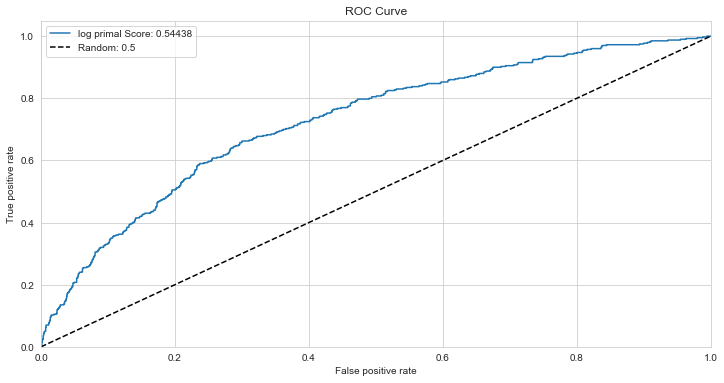

 End of Analysis of ML Algorithm.





In [35]:
def calculate_score(Algorithm,train_x,train_y,test_x,test_y):
    Algorithm.fit(train_x,train_y)
    y_pred = Algorithm.predict(test_x)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(Algorithm.score(test_x, test_y)))
    print('Classification Report :')
    print(classification_report(test_y,Algorithm.predict(test_x)))
    
    
    auc_score=roc_auc_score(test_y,Algorithm.predict(test_x))
    print("AUC Score :",auc_score)
    
    
    fpr,tpr,mpr = roc_curve(test_y,Algorithm.predict_proba(test_x)[:,1])
    
    plt.figure(figsize = (12,6), linewidth= 1)
    plt.plot(fpr,tpr,label = 'log primal Score: ' + str(round(auc_score, 5)))
    plt.plot([0,1], [0,1], '--k', label = 'Random: 0.5')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
    print( " End of Analysis of ML Algorithm.\n\n\n")
    
calculate_score(logistic_alg,df_X_train,df_y_train,df_X_test,df_y_test)